# Profile Classification Model
## Standard Classification workflow demonstration

We're going to classify Argo data with the following workflow:
 - Load netcdf Argo profiles on Standard Depth Levels
 - Normalize profiles
 - Compress the collection with PCA (dimensionality reduction)
 - Train a GMM on the reduced dataset
 - Classify all the dataset
 - Compute class profile statistics
 - Create a map with labels by profiles

Along the way, we'll produce figures to be compared with Maze et al, POC, 2017

@author: gmaze@ifremer.fr

More documentations:
- http://scikit-learn.org
- http://xarray.pydata.org
- http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
- http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- http://scikit-learn.org/stable/modules/mixture.html

*If you run this notebook at colab.research.google.com, you need to install packages with the following command*:

In [ ]:
!pip install --upgrade dask distributed dask-ml xarray zarr gcsfs cftime nc-time-axis intake intake-xarray scikit-learn matplotlib==3.0.2 seaborn
!apt-get -qq install python-cartopy python3-cartopy
!curl https://raw.githubusercontent.com/obidam/ds2-2020/ds2-2021/practice/exploratory_statitics/tuto_tools.py --output tuto_tools.py

## Import modules and libraries

In [4]:
import os
import numpy as np
import xarray, dask
import matplotlib.pyplot as plt
import matplotlib as mpl
# from mpl_toolkits.basemap import Basemap as bm
# import pandas as pd

# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn import preprocessing

# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA

# http://scikit-learn.org/stable/modules/mixture.html
from sklearn.mixture import GaussianMixture

import seaborn as sns
from intake import open_catalog

/Users/gmaze/anaconda/envs/obidam36/lib/python3.6/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['cmip5', 'spark_dataframe', 'spark_rdd', 'spark_cat'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


## Define key parameters of the analysis

In [5]:
# Number of GMM classes to compute:
K = 8

# Compression level for the dimensionality reduction 
maxvar = 99.9 # in %

In [2]:
# Define usefull functions:
def vrange(V): # Return the array value range
    return [np.min(V),np.max(V)]
def vrangec(V): # Return the array value centered range 
    xl = np.max(np.abs(vrange(V)))
    return np.array([-xl,xl])

def create_map(extent=[-80, 0, 0, 70]):
    """Create a figure with a map
        Return fig, proj, ax
    """
    fig = plt.figure(figsize=(12,4),dpi=80)
    proj = ccrs.PlateCarree()
    ax = fig.add_axes([0,0,1,1],projection=proj)
    ax.set_extent(extent, crs=proj)
    gl=ax.gridlines(crs=proj, draw_labels=True,
        linewidth=0.5, color=[0.6]*3, alpha=0.5, linestyle='--')
    # gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,360/10+1))
    # gl.ylocator = mticker.FixedLocator(np.linspace(-90,90,180/5+1))
    gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,360/10+1))
    gl.ylocator = mticker.FixedLocator(np.linspace(-90,90,180/5+1))
    gl.xlabels_top = False
    gl.ylabels_right = False
    ax.add_feature(cfeature.LAND, facecolor=[0.7]*3)
    ax.add_feature(cfeature.COASTLINE)
    return fig, proj, ax

## Load data and create a X[Np,Nz] array to work with

In [5]:
catalog_url = 'https://raw.githubusercontent.com/obidam/ds2-2020/ds2-2021/ds2_data_catalog.yml'
ds = open_catalog(catalog_url).argo_global_homogeneous_sdl.read_chunked()
ds = ds.where(ds['LATITUDE']>0, drop=True)
ds = ds.where(ds['LONGITUDE']>=-80, drop=True)
ds = ds.where(ds['LONGITUDE']<=0, drop=True)
print('This dataset holds: %.3f MB' % (ds.nbytes / 1e6))
print(ds)

This dataset holds: 67.742 MB
<xarray.Dataset>
Dimensions:    (DEPTH: 302, N_PROF: 13950)
Coordinates:
  * DEPTH      (DEPTH) float32 0.0 -5.0 -10.0 -15.0 ... -1495.0 -1500.0 -1505.0
    LATITUDE   (N_PROF) float32 dask.array<shape=(13950,), chunksize=(7170,)>
    LONGITUDE  (N_PROF) float32 dask.array<shape=(13950,), chunksize=(7170,)>
    TIME       (N_PROF) datetime64[ns] dask.array<shape=(13950,), chunksize=(7170,)>
Dimensions without coordinates: N_PROF
Data variables:
    BRV2       (N_PROF, DEPTH) float32 dask.array<shape=(13950, 302), chunksize=(7170, 302)>
    DBINDEX    (N_PROF) float64 dask.array<shape=(13950,), chunksize=(7170,)>
    PSAL       (N_PROF, DEPTH) float32 dask.array<shape=(13950, 302), chunksize=(7170, 302)>
    SIG0       (N_PROF, DEPTH) float32 dask.array<shape=(13950, 302), chunksize=(7170, 302)>
    TEMP       (N_PROF, DEPTH) float32 dask.array<shape=(13950, 302), chunksize=(7170, 302)>
Attributes:
    Title:             VENTHSAL-IA
    conventions:       C

In [6]:
# Select the depth layer for training:
#dsub = ds.sel(DEPTH=slice(-100,-1000))
dsub = ds.sel(DEPTH=slice(0,-1400))

# And Create the array X(Nz,Np): The field to classify with a GMM, 
# Np profiles with Nz depth levels.
X = dsub['TEMP'].values
DPTmodel = dsub['DEPTH'].values
lon = dsub['LONGITUDE'].values
lat = dsub['LATITUDE'].values
          
# Size of the training set X:
[Np, Nz] = X.shape
print("Number of raw features (Depth Levels): ", Nz)
print("Number of samples (N profiles): ", Np)

Number of raw features (Depth Levels):  281
Number of samples (N profiles):  13950


## Normalization
We operate along feature dimensions to:
- Remove the sample mean
- Divide by the sample std

one depth level at a time

Create the Xn[Np,Nz] array

Doc:
http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [11]:
# Fit the scaler object:
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(X)

# The mean and std profiles are in the scaler object properties:
X_ave = scaler.mean_
X_std = scaler.scale_

# Normalize data:
Xn = scaler.transform(X)       

# Here, we only center data:
Xc = preprocessing.StandardScaler(with_std=False).fit(X).transform(X)

# Compute additional statistics, like the observed PDFz:
def diag_pdfz(X,xedges):
    Nz = X.shape[1]
    PDFz = np.zeros((xedges.shape[0]-1,Nz))
    for iz in np.arange(Nz):
        h, hx = np.histogram(X[:,iz],bins=xedges,density=True)
        PDFz[:,iz] = h
    PDFz_axis = hx[0:-1]
    return PDFz, PDFz_axis
PDFz, PDFz_axis = diag_pdfz(X,np.arange(0,30,0.2))

### Time for a figure

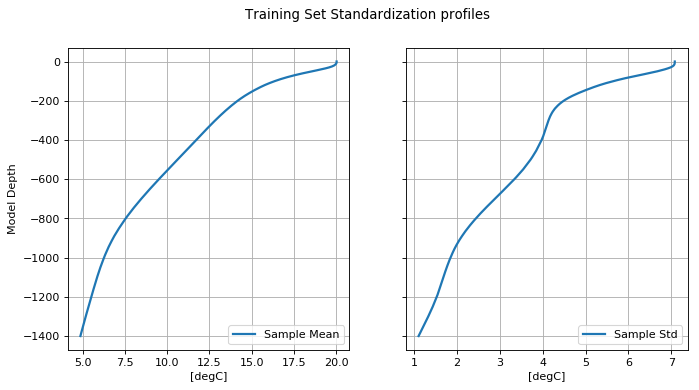

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
ax[0].plot(X_ave, DPTmodel, '-', linewidth=2,label='Sample Mean')
ax[1].plot(X_std, DPTmodel, '-', linewidth=2,label='Sample Std')
# tidy up the figure
ax[0].set_ylabel('Model Depth')
for ix in range(0,2):
    ax[ix].legend(loc='lower right')
    ax[ix].grid(True)
    ax[ix].set_xlabel('[degC]')
fig.suptitle('Training Set Standardization profiles', fontsize=12)
plt.show()

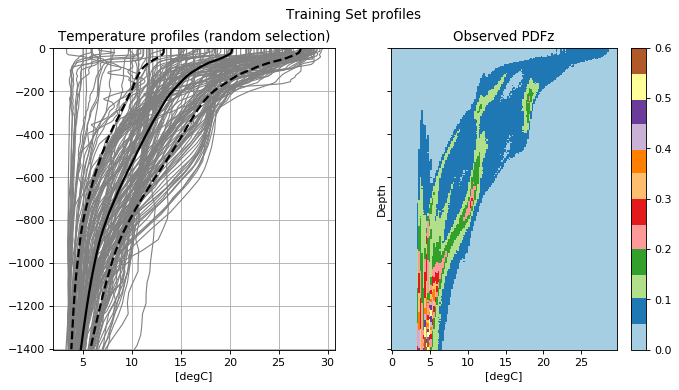

In [13]:
# Select 100 random profiles:
n = 150
ip = np.unique(np.random.randint(0,Np-1,n))

# Random selection of profiles
fig, ax = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
ax[0].plot(X[ip,:].T, np.reshape(np.repeat(DPTmodel,ip.shape[0]),[Nz,ip.shape[0]]), '-', color='gray', linewidth=1)
ax[0].plot(np.mean(X[ip,:].T,axis=1), DPTmodel, '-', color='k', linewidth=2)
ax[0].plot(np.mean(X[ip,:].T,axis=1)-np.std(X[ip,:].T,axis=1), DPTmodel, '--', color='k', linewidth=2)
ax[0].plot(np.mean(X[ip,:].T,axis=1)+np.std(X[ip,:].T,axis=1), DPTmodel, '--', color='k', linewidth=2)
ax[0].grid(True)
ax[0].set_title('Temperature profiles (random selection)')
ax[0].set_xlabel('[degC]')

cmap = plt.get_cmap('Paired',lut=128)
df = xarray.DataArray(PDFz.T, coords=[DPTmodel,PDFz_axis], dims=['Depth','[degC]'])
p = df.plot(cmap=cmap,vmin=0,vmax=0.6,ax=ax[1])
ax[1].set_title("Observed PDFz")

fig.suptitle('Training Set profiles', fontsize=12)
plt.show()

/home8/homedir3/perso/gmaze/miniconda3/envs/obidam36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


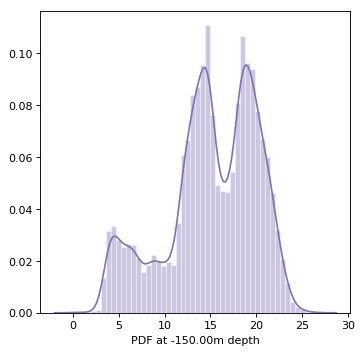

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
sns.set(context="notebook",style="whitegrid", palette="deep", color_codes=True)
iz = 30
sns.distplot(X[:,iz], norm_hist=True, color="m", axlabel="PDF at %0.2fm depth"%(DPTmodel[iz]))
plt.show()

/home8/homedir3/perso/gmaze/miniconda3/envs/obidam36/lib/python3.6/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


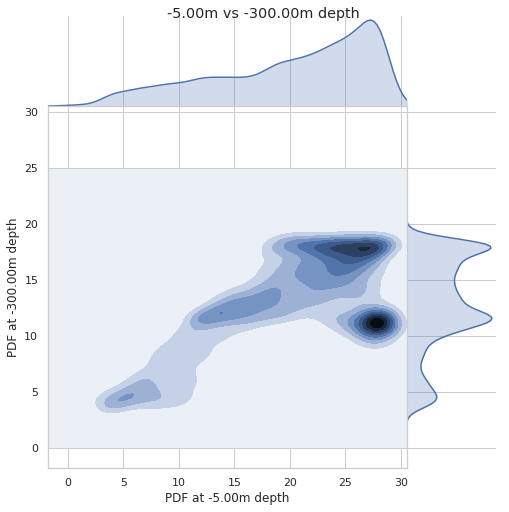

In [15]:
iz1 = 1
iz2 = np.argmax(DPTmodel<=-300)
x = X[:,iz1]
y = X[:,iz2]
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
sns.set(context="notebook", style="whitegrid", color_codes=True)
sns.jointplot(x=x, y=y, kind="kde",\
              xlim=vrange([x,y]),ylim=vrange([x,y]),\
              size=7, ratio=4, space=0)\
            .set_axis_labels("PDF at %0.2fm depth"%(DPTmodel[iz1]), "PDF at %0.2fm depth"%(DPTmodel[iz2]))
plt.suptitle("%0.2fm vs %0.2fm depth"%(DPTmodel[iz1],DPTmodel[iz2]))
plt.show()

## Reduction
Now that we have a standardized collection of profiles, let's compress it with a PCA decomposition

The goal here, is to reduce the dimensionality of the problem from N depths levels down to a couple of principal components

\begin{eqnarray}
	\mathbf{x}(z) &=& \sum_{j=1}^{Nc} \mathbf{P}(z,j) \mathbf{y}(j)
\end{eqnarray}
where $\mathbf{P}\in \mathbb{R}^{Nz\times Nc}$ and $\mathbf{y}\in \mathbb{R}^{Nc\times Np}$ with $Nc\leq Nz$. 
The first rows of $\mathbf{P}$ contain profiles maximizing the structural variance throughout the collection of profiles.

Create the Xr[Np,Nc] array

Doc: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [16]:
# Compute P (the EOFs) from x:
reducer = PCA(n_components=maxvar/100,svd_solver='full')
reducer.fit(Xn)

# Reduce the dataset (compute the y):
Xr = reducer.transform(Xn) # Here we compute: np.dot(Xn - reducer.mean_, np.transpose(reducer.components_))

# Variables of the reduced space:
Nc = reducer.n_components_ # Number of components retained
EOFs = reducer.components_ # [Nc , Nz], the P matrix
V = reducer.explained_variance_ratio_ # Explained variance, with 0 to 1 values

# We can also compute EOFs with real units this way:
S = np.sqrt(reducer.explained_variance_*Xn.shape[0]) # These are the singular values
Z = np.dot(Xn - reducer.mean_, np.transpose(reducer.components_)) # This is simply Xr or the principal components
Ztilde = Z/np.sqrt(S) # Normalized PCs
#EOFs_real = np.dot(np.transpose(Ztilde),X)/X.shape[0] # Regression on any collection of profiles
EOFs_realc = np.dot(np.transpose(Ztilde),Xc)/Xc.shape[0] # Regression on any collection of profiles
EOFs_real = np.dot(np.transpose(Ztilde),Xn)/Xn.shape[0] # Regression on any collection of profiles

# Compute the RMS difference between the reconstructed and original dataset:
Xn_reconstructed = reducer.inverse_transform(Xr)
X_reconstructed = scaler.inverse_transform(Xn_reconstructed)
rms = np.sqrt(np.mean(np.square(X_reconstructed-X),axis=0))

#
print("\nWe reduced the dimensionality of the problem from %i depth levels down to %i PCs\n"%(Nz,Nc))


We reduced the dimensionality of the problem from 281 depth levels down to 13 PCs



### Figures with PCA decomposition details

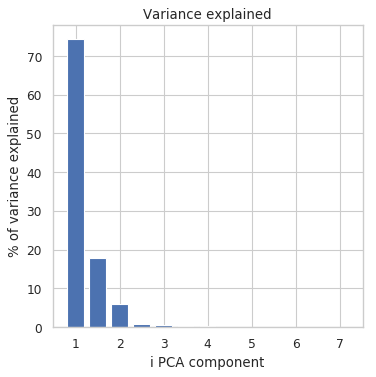

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
ax.bar(range(0,Nc),V*100)
ax.set_xlabel('i PCA component')
ax.set_ylabel('% of variance explained')
ax.grid(True)
ax.set_xticklabels(range(0,Nc))
ax.set_title('Variance explained')
plt.show()

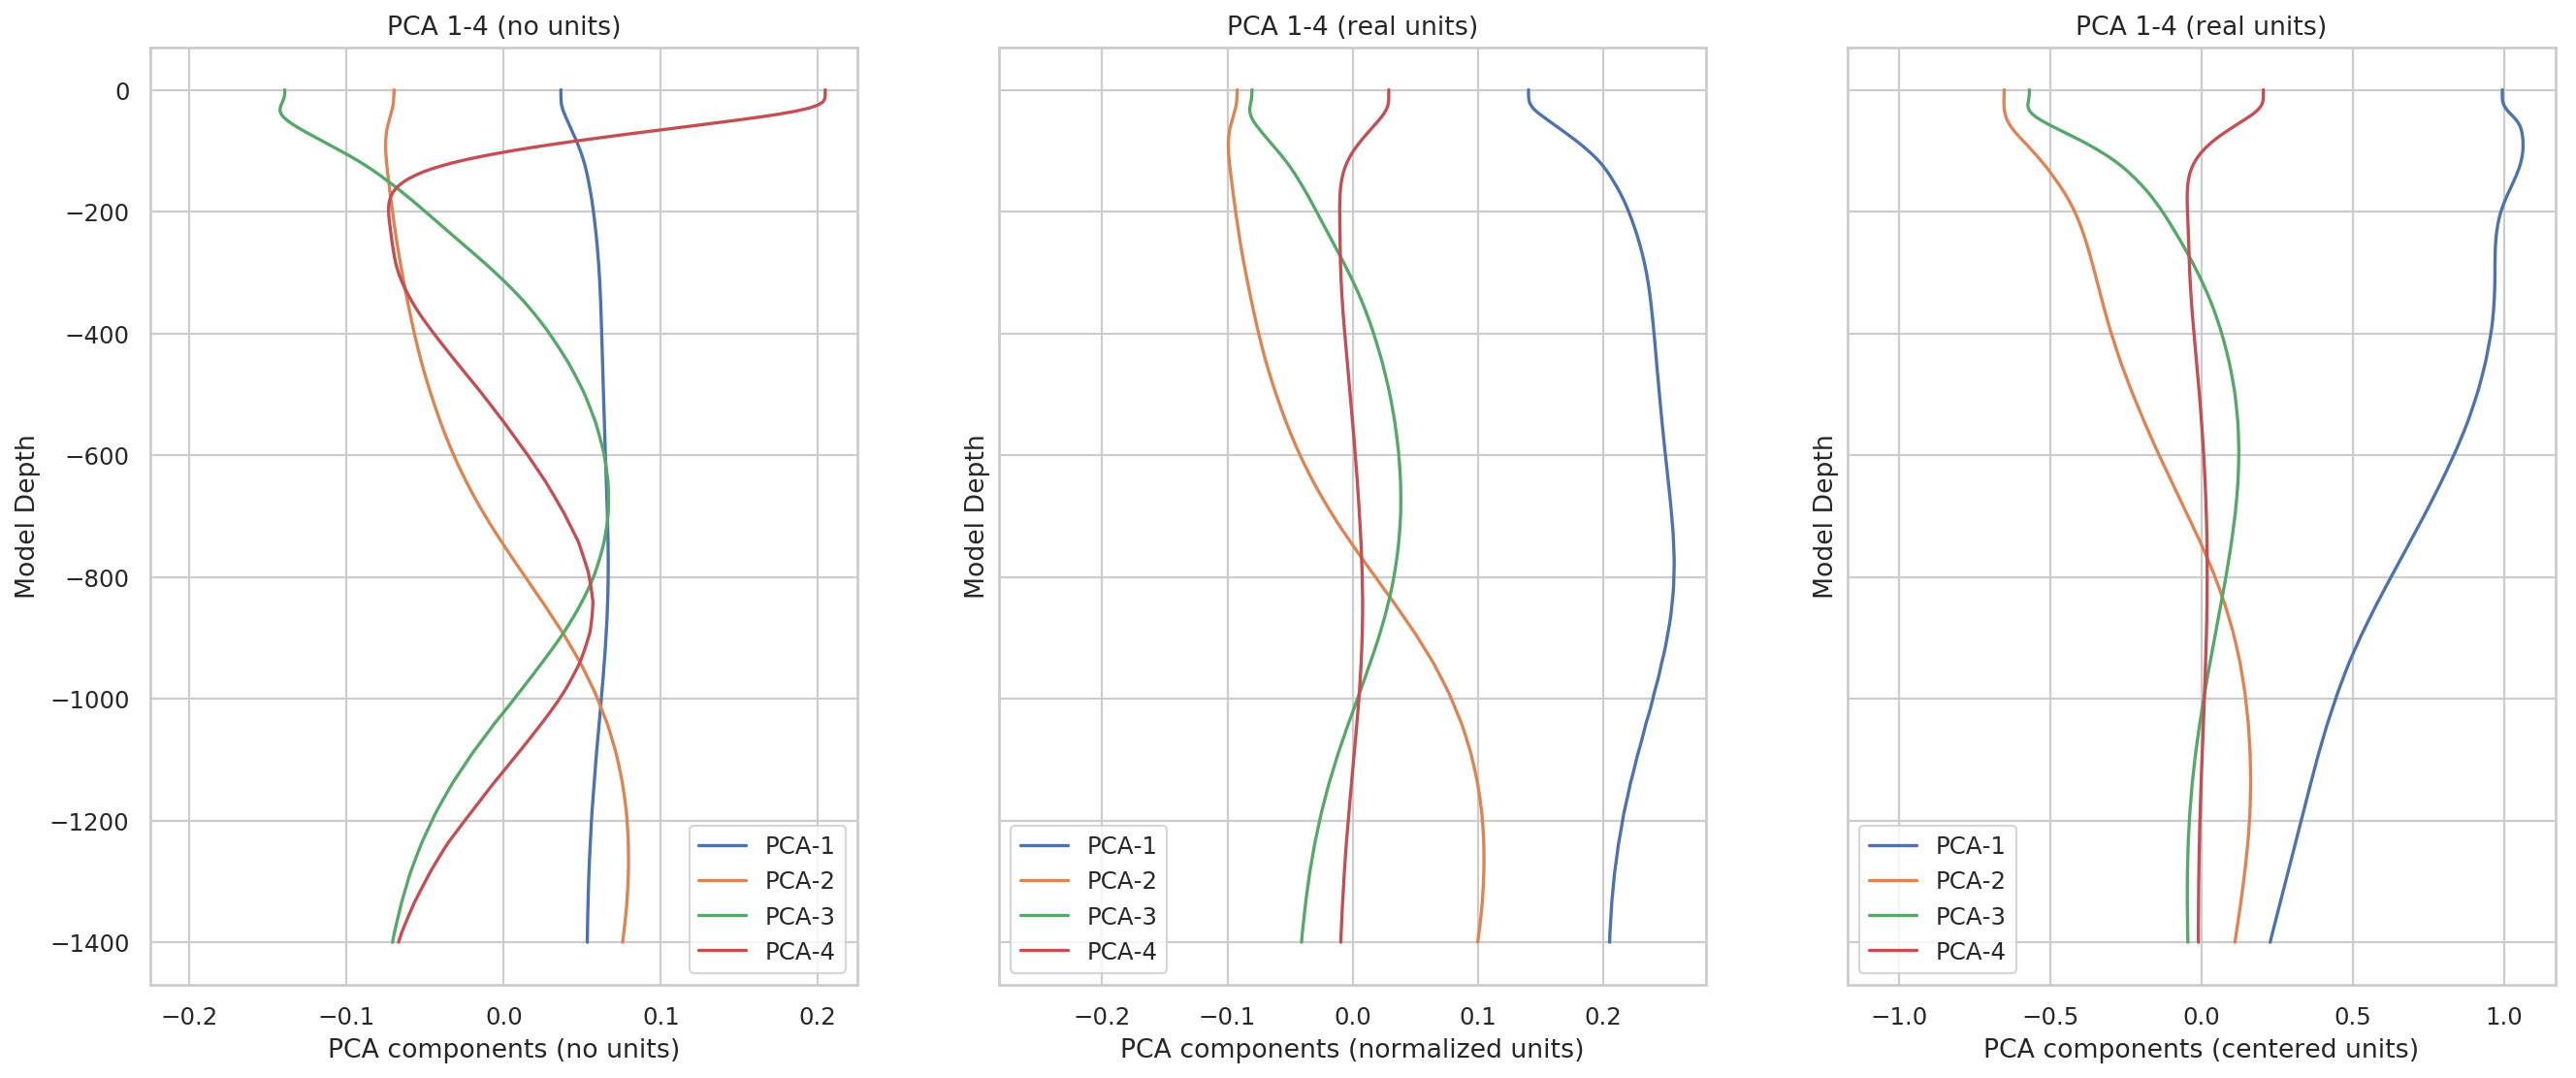

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,8), dpi=160, facecolor='w', edgecolor='k', sharey='row')

iax = 0
xl = np.max(np.abs([np.min(EOFs),np.max(EOFs)]))
for ie in range(0,4):
    ax[iax].plot(np.transpose(EOFs[ie,:]),DPTmodel,label="PCA-%i"%(ie+1))
ax[iax].set_xlim(1.1*np.array([-xl,xl]))
ax[iax].legend(loc='lower right')
ax[iax].set_xlabel('PCA components (no units)')
ax[iax].set_ylabel('Model Depth')
ax[iax].grid(True)
ax[iax].set_title('PCA 1-4 (no units)')

iax+=1
xl = np.max(np.abs([np.min(EOFs_real),np.max(EOFs_real)]))
for ie in range(0,4):
    ax[iax].plot(np.transpose(EOFs_real[ie,:]),DPTmodel,label="PCA-%i"%(ie+1))
ax[iax].set_xlim(1.1*np.array([-xl,xl]))
ax[iax].legend(loc='lower left')
ax[iax].set_xlabel('PCA components (normalized units)')
ax[iax].set_ylabel('Model Depth')
ax[iax].grid(True)
ax[iax].set_title('PCA 1-4 (real units)')

iax+=1
xl = np.max(np.abs([np.min(EOFs_realc),np.max(EOFs_realc)]))
for ie in range(0,4):
    ax[iax].plot(np.transpose(EOFs_realc[ie,:]),DPTmodel,label="PCA-%i"%(ie+1))
ax[iax].set_xlim(1.1*np.array([-xl,xl]))
ax[iax].legend(loc='lower left')
ax[iax].set_xlabel('PCA components (centered units)')
ax[iax].set_ylabel('Model Depth')
ax[iax].grid(True)
ax[iax].set_title('PCA 1-4 (real units)')
plt.show()

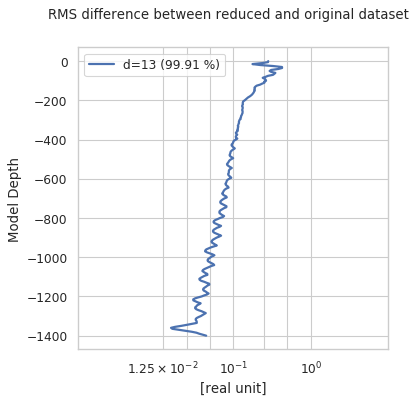

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
ax.semilogx(rms, DPTmodel, '-', linewidth=2,label="d=%i (%0.2f %%)"%(Nc,np.sum(V*100)))
# tidy up the figure
ax.legend(loc='upper left')
ax.set_xticks([0.0125,0.025,0.05,0.1,0.25,0.5,1])
ax.set_xlim([1e-3,1e1])
ax.set_xlabel('[real unit]')
ax.set_ylabel('Model Depth')
ax.grid(True)
fig.suptitle('RMS difference between reduced and original dataset', fontsize=12)
plt.show()

## GMM Classification
We classify with a GMM the reduce dataset

Doc: http://scikit-learn.org/stable/modules/mixture.html

In [20]:
%%time
# Set-up and train the classifier:
gmm = GaussianMixture(n_components=K,\
                      covariance_type='full',\
                      init_params='kmeans',\
                      max_iter=1000,\
                      tol=1e-6)
gmm.fit(Xr) # Training on reduced data

# Extract GMM parameters:
priors = gmm.weights_ # [K,1]
centers= gmm.means_   # [K,Nc]
covars = gmm.covariances_ # [K,Nc,Nc] if 'full'

In [21]:
# Classify the dataset:
LABELS = gmm.predict(Xr) # [Np,1]
POST   = gmm.predict_proba(Xr) # [Np,Nc]

## Time for a lot of figures

In [23]:
def plot_GMMellipse(gmm,id,ik,col,ax,label="",std=[1],main_axes=True,**kwargs):
    """
        Plot an 1-STD ellipse for a given component (ik) and 2 given dimensions (id) 
        of the GMM model gmm
        This is my routine, simply working with a matplotlib plot method
        I also added the possiblity to plot the main axes of the ellipse
    """
    covariances = gmm.covariances_[ik][(id[0],id[0],id[1],id[1]),(id[0],id[1],id[0],id[1])].reshape(2,2)
    d, v = np.linalg.eigh(covariances) #  eigenvectors have unit length
    d = np.diag(d)
    theta = np.arange(0,2*np.pi,0.02)
    x = np.sqrt(d[0,0])*np.cos(theta)
    y = np.sqrt(d[1,1])*np.sin(theta)
    xy = np.array((x,y)).T
    ii = 0
    for nstd in np.array(std):
        ii+=1
        ellipse = np.inner(v,xy).T
        ellipse = nstd*ellipse + np.ones((theta.shape[0], 1))*gmm.means_[ik,(id[0],id[1])]
        if ii == 1:
#            p = ax.plot(ellipse[:,0], ellipse[:,1], color=col, axes=ax, label=("%s (%i-std)")%(label,nstd),**kwargs)
            p = ax.plot(ellipse[:,0], ellipse[:,1], color=col, axes=ax, label=("%s")%(label),**kwargs)
        else:
            p = ax.plot(ellipse[:,0], ellipse[:,1], color=col, axes=ax,**kwargs)
    if main_axes: # Add Main axes:
        for idir in range(2):
            l = np.sqrt(d[idir,idir])*v[:,idir].T
            start = gmm.means_[ik,(id[0],id[1])]-l
            endpt = gmm.means_[ik,(id[0],id[1])]+l
            linex = [start[0], endpt[0]]
            liney = [start[1], endpt[1]]
            plt.plot(linex,liney,color=col,axes=ax)
    return p,ax

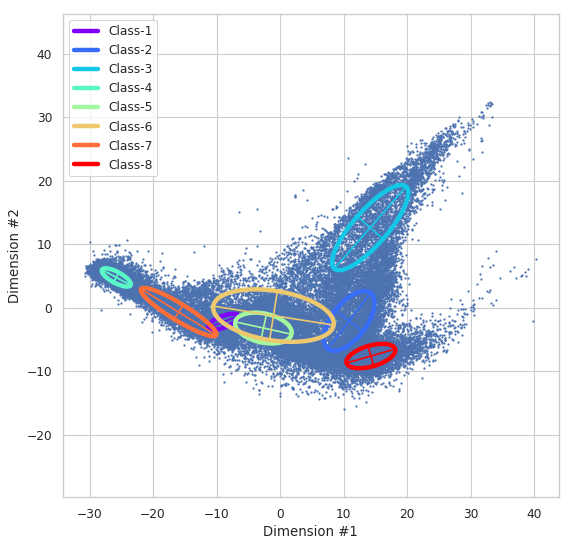

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')
id = np.array([1,2])-1
ax.scatter(Xr[:,id[0]],Xr[:,id[1]],1)
ax.grid(True)
ax.axis('equal')
ax.set_xlabel("Dimension #%i"%(id[0]+1))
ax.set_ylabel("Dimension #%i"%(id[1]+1))
colors = mpl.colors.cnames.items()
colors = iter(plt.cm.rainbow(np.linspace(0, 1, K)))
for ik in np.arange(K):
    el,ax = plot_GMMellipse(gmm,id,ik,next(colors),ax,label="Class-%i"%(ik+1),linewidth=4)                            
#    el,ax = plot_GMMellipse(gmm,id,ik,next(colors),ax,label="Class-%i"%(ik+1),std=[1],linewidth=4)
ax.legend(loc='upper left')
plt.show()

In [25]:
def sns_GMMellipse(x,y,gmm=[],id=[],std=[1],main_axes=True,label="?",**kwargs):
    """
        Plot an 1-STD ellipse for a given component (ik) and 2 given dimensions (id) 
        of the GMM model gmm
        This is my routine, simply working with a matplotlib plot method
        I also added the possiblity to plot the main axes of the ellipse
    """
    K = gmm.n_components
#    colors = iter(plt.cm.rainbow(np.linspace(0, 1, K)))
    colors = sns.color_palette("Paired", K)
    for ik in np.arange(K):
#        col = next(colors)
        col = colors[ik]
        covariances = gmm.covariances_[ik][(id[0],id[0],id[1],id[1]),(id[0],id[1],id[0],id[1])].reshape(2,2)
        d, v = np.linalg.eigh(covariances) #  eigenvectors have unit length
        d = np.diag(d)
        theta = np.arange(0,2*np.pi,0.02)
        x = np.sqrt(d[0,0])*np.cos(theta)
        y = np.sqrt(d[1,1])*np.sin(theta)
        xy = np.array((x,y)).T
        ii = 0
        for nstd in np.array(std):
            ii+=1
            ellipse = np.inner(v,xy).T
            ellipse = nstd*ellipse + np.ones((theta.shape[0], 1))*gmm.means_[ik,(id[0],id[1])]
            if ii == 1:
                plt.plot(ellipse[:,0], ellipse[:,1], color=col, label=("%s")%(label),**kwargs)
            else:
                plt.plot(ellipse[:,0], ellipse[:,1], color=col, **kwargs)
        if main_axes: # Add Main axes:
            for idir in range(2):
                l = np.sqrt(d[idir,idir])*v[:,idir].T
                start = gmm.means_[ik,(id[0],id[1])]-l
                endpt = gmm.means_[ik,(id[0],id[1])]+l
                linex = [start[0], endpt[0]]
                liney = [start[1], endpt[1]]
                plt.plot(linex,liney,color=col)

/home8/homedir3/perso/gmaze/miniconda3/envs/obidam36/lib/python3.6/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/home8/homedir3/perso/gmaze/miniconda3/envs/obidam36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


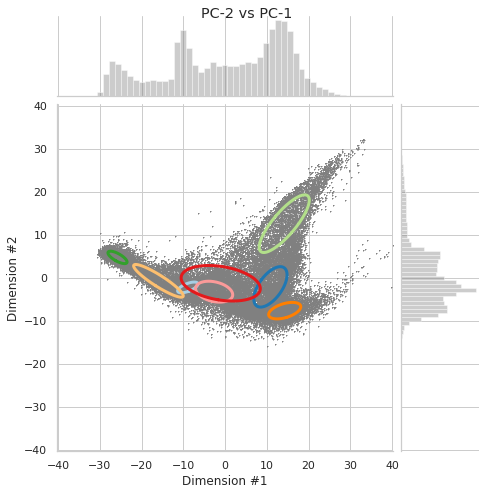

In [27]:
import pandas as pd
df = pd.DataFrame(Xr[:,id], columns=["x", "y"])
sns.set(context="notebook",style="whitegrid", color_codes=True)
g = sns.JointGrid(x="x", y="y", data=df, size=7, ratio=4, space=0.1,
                  xlim=vrangec(Xr[:,id]),ylim=vrangec(Xr[:,id]))

g.plot_marginals(sns.distplot, kde=False, color=".5")

g.plot_joint(plt.scatter, c=".5", s=1, linewidth=1, marker="+")

g.plot_joint(sns_GMMellipse, gmm=gmm, id=id, main_axes=False, linewidth=3)

g.set_axis_labels("Dimension #%i"%(id[0]+1), "Dimension #%i"%(id[1]+1))
g.fig.suptitle("PC-%i vs PC-%i"%(id[1]+1,id[0]+1))
plt.show()

/home8/homedir3/perso/gmaze/miniconda3/envs/obidam36/lib/python3.6/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/home8/homedir3/perso/gmaze/miniconda3/envs/obidam36/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'kind'
  s)


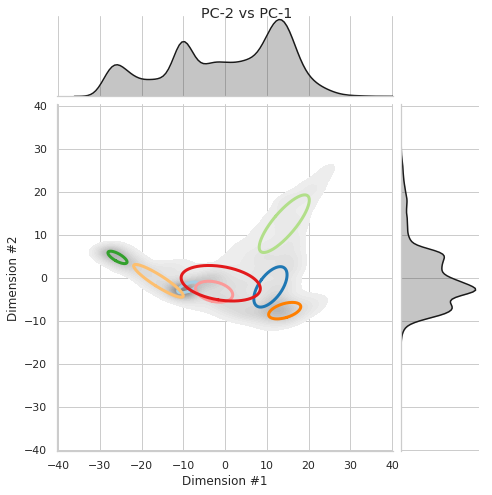

/home8/homedir3/perso/gmaze/miniconda3/envs/obidam36/lib/python3.6/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/home8/homedir3/perso/gmaze/miniconda3/envs/obidam36/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'kind'
  s)


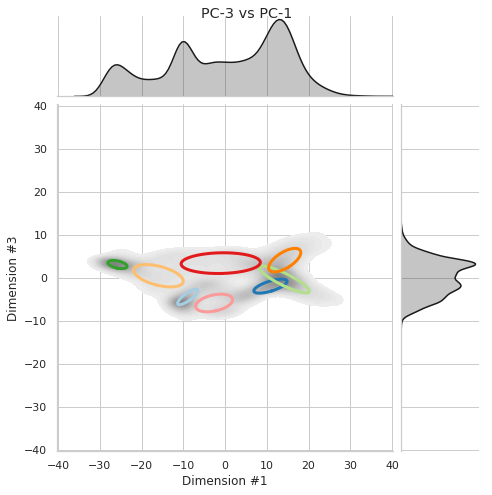

In [28]:
for ii in np.arange(2,4):
    id = np.array([1,ii])-1
    df = pd.DataFrame(Xr[:,id], columns=["x", "y"])
    sns.set(context="notebook",style="whitegrid", color_codes=True)
    g = sns.JointGrid(x="x", y="y", data=df, size=7, ratio=4, space=0.1,
                      xlim=vrangec(Xr[:,id]),ylim=vrangec(Xr[:,id]))
    #g.plot_joint(sns.kdeplot, cmap="Purples_d", kind='hex', linewidth=1, color='k', n_levels=30)
    #g.plot_joint(sns.kdeplot, shade = True, cmap="Purples_d", kind='hex', n_levels=30)
    g.plot_joint(sns.kdeplot, shade = True, \
                 shade_lowest=False,\
                 cmap=sns.light_palette("gray",reverse=False,as_cmap=True), kind='hex', n_levels=30)
    #g.plot_joint(sns.kdeplot, shade = False, kind='hex', n_levels=10)
    g.plot_marginals(sns.kdeplot, color="k", shade=True)

    g.plot_joint(sns_GMMellipse, gmm=gmm, id=id, main_axes=False, linewidth=3)

    g.set_axis_labels("Dimension #%i"%(id[0]+1), "Dimension #%i"%(id[1]+1))
    g.fig.suptitle("PC-%i vs PC-%i"%(id[1]+1,id[0]+1))
    plt.show()

/home8/homedir3/perso/gmaze/miniconda3/envs/obidam36/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home8/homedir3/perso/gmaze/miniconda3/envs/obidam36/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


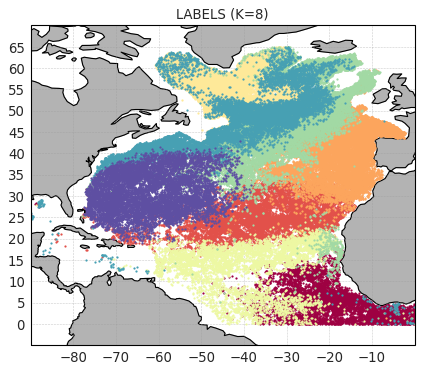

In [40]:
# Plot LABELS map:
unique_labels = set(LABELS)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

fig, proj, ax = create_map(extent=[-90, 0, -5, 70], dpi=80)

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 0.2]
    class_member_mask = (LABELS == k)

    plt.plot(lon[class_member_mask],
                lat[class_member_mask],
                 'o', markerfacecolor=tuple(col),
                 markeredgecolor='none', markersize=2,  
             label="Class %i"%(k), transform=proj)

plt.title("LABELS (K=%i)"%(K))
# plt.legend()
plt.show()

/home8/homedir3/perso/gmaze/miniconda3/envs/obidam36/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home8/homedir3/perso/gmaze/miniconda3/envs/obidam36/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


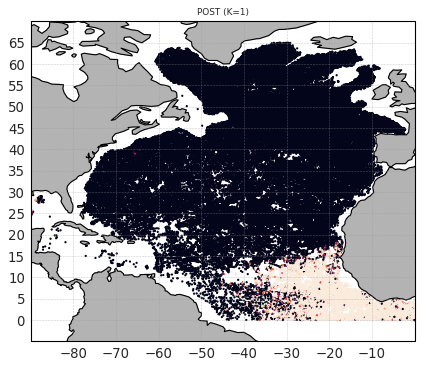

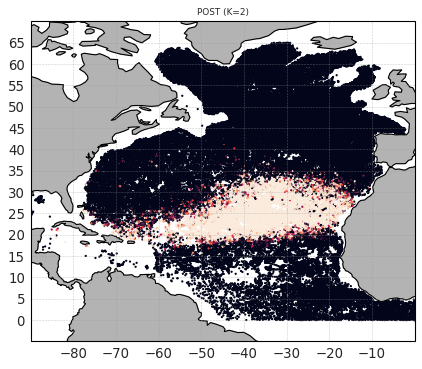

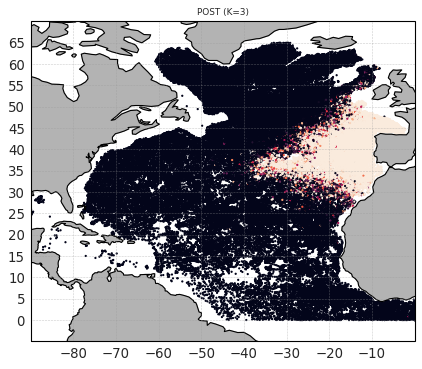

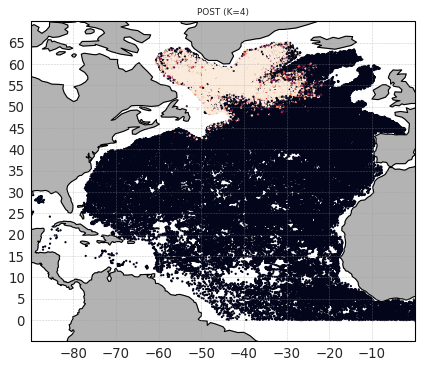

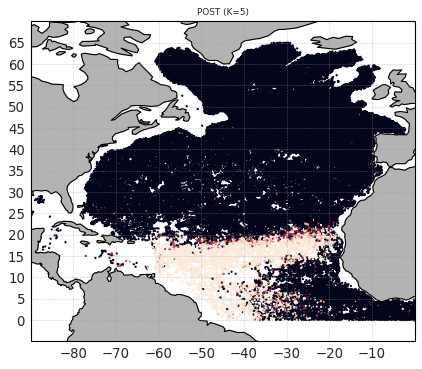

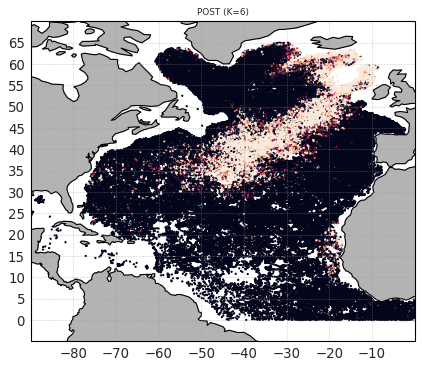

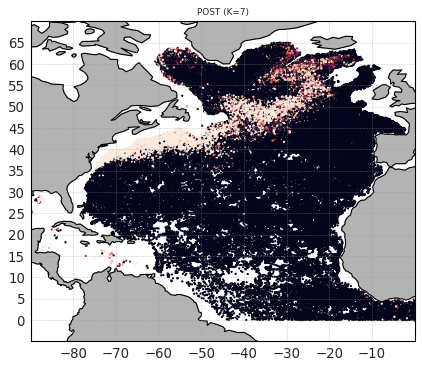

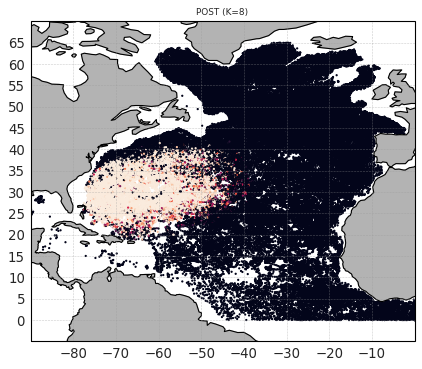

In [41]:
# Plot POSTERIORS map:
for k, col in zip(unique_labels, colors):
    fig, proj, ax = create_map(extent=[-90, 0, -5, 70], dpi=60)
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 0.2]
#     class_member_mask = (LABELS == k)

    plt.scatter(lon,lat,1,POST[:,k], transform=proj)

    plt.title("POST (K=%i)"%(k+1),fontsize=8)
plt.show()

# Exercise

Compute and plot the robustness of the classification